In [55]:
import os
import time
import h5py
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import tensorflow as tf
from scipy import misc
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
from skimage.transform import rescale, resize, downscale_local_mean
from tqdm import tqdm
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.losses import binary_crossentropy
import keras.backend.tensorflow_backend as KTF
%matplotlib inline

In [ ]:
DATA_PATH = '/kaggle/dev/carvana-image-masking-challenge-data'
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw_data')
TRAIN_PATH = os.path.join(RAW_DATA_PATH, 'train')
TEST_PATH = os.path.join(RAW_DATA_PATH, 'test')
TRAIN_MASKS_PATH = os.path.join(RAW_DATA_PATH, 'train_masks')
TRAIN_MASKS_CSV_PATH = os.path.join(RAW_DATA_PATH, 'train_masks.csv')
SAMPLE_SUBMISSION_PATH = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
METADATA_PATH = os.path.join(RAW_DATA_PATH, 'metadata.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
ASSETS_PATH = os.path.join(DATA_PATH, 'assets')
MODELS_PATH = os.path.join(ASSETS_PATH, 'models')
TENSORBOARD_PATH = os.path.join(ASSETS_PATH, 'tensorboard')

In [ ]:
train_masks_df = pd.read_csv(TRAIN_MASKS_CSV_PATH)
print('train_masks_df.shape', train_masks_df.shape)
train_masks_df.head()

In [ ]:
def get_img_id(img_path):
    return img_path[:15]

img_ids = list(map(get_img_id, list(train_masks_df.img.values)))
img_ids[0:10]

In [ ]:
def load_image(img_id, folder=TRAIN_PATH):
    img = misc.imread(os.path.join(folder, img_id + ".jpg"))
    return img

# Return mask as 1/0 binary img
def load_mask(img_id):
    mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    mask = mask[:,:,0:3]
    mask[mask == 255] = 1
    if mask.shape[2] == 3:
        mask = np.mean(mask, axis = 2)
        mask = mask.reshape(mask.shape[0], mask.shape[1], -1)
    return mask

# Helper functions to plot car, mask, masked_car
def plot_image(img_id):
    img = misc.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def plot_mask(img_id):
    mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    imgplot = plt.imshow(mask)
    plt.axis('off')
    plt.show()
    
def plot_masked_image(img_id):
    img = misc.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    mask = mask[:,:,0:3]
    mask[mask == 255] = 1 
    masked_img = img * mask
    imgplot = plt.imshow(masked_img)
    plt.axis('off')
    plt.show()
    
def resize_img(img, factor=0.1):
    #return downscale_local_mean(img, (factor,factor,1))
    return rescale(img, factor)

(1280, 1918, 3)


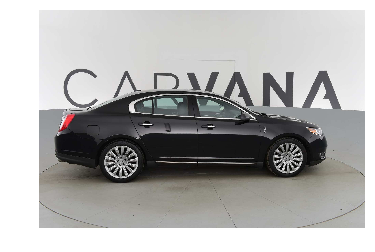

In [19]:
random_car_idx = int(np.random.random() * len(train_masks_df))
img = load_image(img_ids[random_car_idx])
print(img.shape)
plot_image(img_ids[random_car_idx])

In [20]:
HEIGHT_ORIG = img.shape[0]
WIDTH_ORIG = img.shape[1]
CHANNELS_ORIG = img.shape[2]

/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(128, 192, 3)


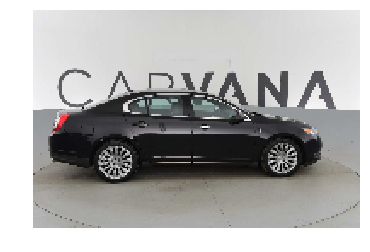

In [21]:
img = resize_img(img)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

In [22]:
# Constants
HEIGHT = img.shape[0]
WIDTH = img.shape[1]
CHANNELS = img.shape[2]

In [23]:
def generate_training_batch(data, batch_size):
    X = np.zeros((batch_size, HEIGHT, WIDTH, CHANNELS))
    Y = np.zeros((batch_size, HEIGHT, WIDTH, 1))
    while True:
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        for idx, img_id in enumerate(batch_ids):
            X[idx] = resize_img(load_image(img_id))
            Y[idx] = resize_img(load_mask(img_id))

        yield X, Y

def generate_validation_batch(data, batch_size):
    X = np.zeros((batch_size, HEIGHT, WIDTH, CHANNELS))
    Y = np.zeros((batch_size, HEIGHT, WIDTH, 1))
    while True:
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        for idx, img_id in enumerate(batch_ids):
            X[idx] = resize_img(load_image(img_id))
            Y[idx] = resize_img(load_mask(img_id))

        yield X, Y

In [55]:
# def resize_images_bilinear(X, height_factor=1, width_factor=1, target_height=None, target_width=None, data_format='default'):
#     '''Resizes the images contained in a 4D tensor of shape
#     - [batch, channels, height, width] (for 'channels_first' data_format)
#     - [batch, height, width, channels] (for 'channels_last' data_format)
#     by a factor of (height_factor, width_factor). Both factors should be
#     positive integers.
#     '''
#     if data_format == 'default':
#         data_format = K.image_data_format()
#     if data_format == 'channels_first':
#         original_shape = K.int_shape(X)
#         if target_height and target_width:
#             new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
#         else:
#             new_shape = tf.shape(X)[2:]
#             new_shape *= tf.constant(np.array([height_factor, width_factor]).astype('int32'))
#         X = permute_dimensions(X, [0, 2, 3, 1])
#         X = tf.image.resize_bilinear(X, new_shape)
#         X = permute_dimensions(X, [0, 3, 1, 2])
#         if target_height and target_width:
#             X.set_shape((None, None, target_height, target_width))
#         else:
#             X.set_shape((None, None, original_shape[2] * height_factor, original_shape[3] * width_factor))
#         return X
#     elif data_format == 'channels_last':
#         original_shape = K.int_shape(X)
#         if target_height and target_width:
#             new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
#         else:
#             new_shape = tf.shape(X)[1:3]
#             new_shape *= tf.constant(np.array([height_factor, width_factor]).astype('int32'))
#         X = tf.image.resize_bilinear(X, new_shape)
#         if target_height and target_width:
#             X.set_shape((None, target_height, target_width, None))
#         else:
#             X.set_shape((None, original_shape[1] * height_factor, original_shape[2] * width_factor, None))
#         return X
#     else:
#         raise Exception('Invalid data_format: ' + data_format)

# class BilinearUpSampling2D(Layer):
#     def __init__(self, size=(1, 1), target_size=None, data_format='default', **kwargs):
#         if data_format == 'default':
#             data_format = K.image_data_format()
#         self.size = tuple(size)
#         if target_size is not None:
#             self.target_size = tuple(target_size)
#         else:
#             self.target_size = None
#         assert data_format in {'channels_last', 'channels_first'}, 'data_format must be in {tf, th}'
#         self.data_format = data_format
#         self.input_spec = [InputSpec(ndim=4)]
#         super(BilinearUpSampling2D, self).__init__(**kwargs)

#     def get_output_shape_for(self, input_shape):
#         if self.data_format == 'channels_first':
#             width = int(self.size[0] * input_shape[2] if input_shape[2] is not None else None)
#             height = int(self.size[1] * input_shape[3] if input_shape[3] is not None else None)
#             if self.target_size is not None:
#                 width = self.target_size[0]
#                 height = self.target_size[1]
#             return (input_shape[0],
#                     input_shape[1],
#                     width,
#                     height)
#         elif self.data_format == 'channels_last':
#             width = int(self.size[0] * input_shape[1] if input_shape[1] is not None else None)
#             height = int(self.size[1] * input_shape[2] if input_shape[2] is not None else None)
#             if self.target_size is not None:
#                 width = self.target_size[0]
#                 height = self.target_size[1]
#             return (input_shape[0],
#                     width,
#                     height,
#                     input_shape[3])
#         else:
#             raise Exception('Invalid data_format: ' + self.data_format)

#     def call(self, x, mask=None):
#         if self.target_size is not None:
#             return resize_images_bilinear(x, target_height=self.target_size[0], target_width=self.target_size[1], data_format=self.data_format)
#         else:
#             return resize_images_bilinear(x, height_factor=self.size[0], width_factor=self.size[1], data_format=self.data_format)

#     def get_config(self):
#         config = {'size': self.size, 'target_size': self.target_size}
#         base_config = super(BilinearUpSampling2D, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

In [56]:
# Model
# def FCN_Vgg16_32s(weight_decay=0.00005, batch_momentum=0.9, classes=2):
#     img_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
#     image_size = (HEIGHT, WIDTH, CHANNELS)
    
#     # Block 1
#     x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
#     #x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

#     # Block 2
#     x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
#     #x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

#     # Block 3
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
#     #x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
#     #x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#     # Block 4
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
#     #x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
#     #x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#     # Block 5
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=l2(weight_decay))(x)
#     #x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_regularizer=l2(weight_decay))(x)
#     #x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_regularizer=l2(weight_decay))(x)

#     # Convolutional layers transfered from fully-connected layers
#     x = AtrousConv2D(4096, (7, 7), activation='relu', padding='same', atrous_rate=(2, 2),
#                       name='fc1', kernel_regularizer=l2(weight_decay))(x)
#     x = Dropout(0.5)(x)
#     x = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
#     x = Dropout(0.5)(x)
#     #classifying layer
#     x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

#     output = BilinearUpSampling2D(target_size=tuple(image_size))(x)
    
#     model = Model(inputs=img_input, outputs=output)
#     return model

In [15]:
# import densenet_fc as dc

# model = dc.DenseNetFCN((HEIGHT, WIDTH, CHANNELS), nb_dense_block=5, growth_rate=16,
#                         nb_layers_per_block=4, upsampling_type='upsampling', classes=1, batchsize=BATCH_SIZE)

In [45]:
# First let's define the two different types of layers that we will be using.

def down(input_layer, filters, pool=True):
    x = Conv2D(filters, (3, 3), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if pool:
        x_pool = MaxPooling2D((2, 2), strides=(2, 2))(x)
        return x_pool, x
    else:
        return x

def up(input_layer, residual, filters):
    filters = int(filters)
    x = UpSampling2D((2, 2))(input_layer)
    x = concatenate([residual, x], axis=3)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [46]:
# Make a custom U-nets implementation.

def unet():
    filters = 64
    input_layer = Input(shape = [HEIGHT, WIDTH, CHANNELS])
    layers = [input_layer]
    residuals = []

    # Down 1, 128
    d1, res1 = down(input_layer, filters)
    residuals.append(res1)

    filters *= 2

    # Down 2, 64
    d2, res2 = down(d1, filters)
    residuals.append(res2)

    filters *= 2

    # Down 3, 32
    d3, res3 = down(d2, filters)
    residuals.append(res3)

    filters *= 2

    # Down 4, 16
    d4, res4 = down(d3, filters)
    residuals.append(res4)

    filters *= 2

    # Down 5, 8
    d5 = down(d4, filters, pool=False)

    # Up 1, 16
    up1 = up(d5, residual=residuals[-1], filters=filters/2)

    filters /= 2

    # Up 2,  32
    up2 = up(up1, residual=residuals[-2], filters=filters/2)

    filters /= 2

    # Up 3, 64
    up3 = up(up2, residual=residuals[-3], filters=filters/2)

    filters /= 2

    # Up 4, 128
    up4 = up(up3, residual=residuals[-4], filters=filters/2)

    output = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

    model = Model(inputs=input_layer, outputs=output)
    
    return model

In [59]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

In [60]:
BATCH_SIZE = 8

In [61]:
ts = str(int(time.time()))
model_name = 'malhot'
num_epochs = 100
steps_per_epoch = 400
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)
tensorboard_loc = os.path.join(TENSORBOARD_PATH, run_name)
checkpoint_loc = os.path.join(MODELS_PATH, 'model-{}-weights-{epoch:02d}-{val_loss:.2f}.h5'.format(ts))

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.0001,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(checkpoint_loc,
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0, write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, earlyStopping, tensorboard]

model = unet()
model.compile(loss=bce_dice_loss, optimizer=Adam(1e-4), metrics=[dice_coef])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 128, 192, 3)   0                                            
____________________________________________________________________________________________________
conv2d_71 (Conv2D)               (None, 128, 192, 64)  1792        input_5[0][0]                    
____________________________________________________________________________________________________
batch_normalization_45 (BatchNor (None, 128, 192, 64)  256         conv2d_71[0][0]                  
____________________________________________________________________________________________________
activation_45 (Activation)       (None, 128, 192, 64)  0           batch_normalization_45[0][0]     
___________________________________________________________________________________________

In [66]:
train_ids, validation_ids = model_selection.train_test_split(img_ids, random_state=42, test_size=0.20)
train_generator = generate_training_batch(train_ids, BATCH_SIZE)
valid_generator = generate_validation_batch(validation_ids, BATCH_SIZE)

VALIDATION_STEPS = int(len(validation_ids) / BATCH_SIZE)
print('Starting run {}'.format(run_name))
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = 318, 
        epochs = 30,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = VALIDATION_STEPS)

model_path = os.path.join(MODELS_PATH, 'model-{}.h5'.format(ts))
history_path = os.path.join(MODELS_PATH, 'model-{}.history'.format(ts))
model.save(model_path)
pickle.dump(history.history, open(history_path, "wb"))
print('Saved model at {}'.format(model_path))
print('Saved model history at {}'.format(history_path))

Starting run model=malhot-batch_size=8-num_epoch=100-steps_per_epoch=400-ts=1503722301
Epoch 1/10


/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


318/318 [==============================] - 1044s - loss: 0.0158 - dice_coef: 0.9918 - val_loss: 0.0177 - val_dice_coef: 0.9912
Epoch 2/10
318/318 [==============================] - 970s - loss: 0.0210 - dice_coef: 0.9904 - val_loss: 0.0172 - val_dice_coef: 0.9914
Epoch 3/10
318/318 [==============================] - 969s - loss: 0.0200 - dice_coef: 0.9907 - val_loss: 0.0184 - val_dice_coef: 0.9908
Epoch 4/10
318/318 [==============================] - 966s - loss: 0.0195 - dice_coef: 0.9911 - val_loss: 0.0171 - val_dice_coef: 0.9915
Epoch 5/10
318/318 [==============================] - 972s - loss: 0.0159 - dice_coef: 0.9923 - val_loss: 0.0162 - val_dice_coef: 0.9920
Epoch 6/10
318/318 [==============================] - 995s - loss: 0.0207 - dice_coef: 0.9905 - val_loss: 0.0174 - val_dice_coef: 0.9913
Epoch 7/10
318/318 [==============================] - 953s - loss: 0.0186 - dice_coef: 0.9915 - val_loss: 0.0161 - val_dice_coef: 0.9920
Epoch 00006: early stopping
Saved model at /kaggle/

In [67]:
model.evaluate_generator(valid_generator, VALIDATION_STEPS)

/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[0.01614623836527659, 0.99205401469403365]

In [68]:
# Helper methods
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def gray2rgb(img):
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = img
    ret[:, :, 1] = img
    ret[:, :, 2] = img
    return ret

def load_imgs(img_ids, folder=TRAIN_PATH):
    imgs = []
    for img_id in img_ids:
        img = misc.imread(os.path.join(folder, img_id + ".jpg"))
        imgs.append(img)
    return np.asarray(imgs)

def resize_imgs(imgs, factor=0.1):
    resized_imgs = []
    for img in imgs:
        resized_img = rescale(img, factor)
        resized_imgs.append(resized_img)
    return np.asarray(resized_imgs)

def rescale_and_clean_masks(masks):
    clean_masks = np.zeros((masks.shape[0], HEIGHT_ORIG, WIDTH_ORIG, 1), dtype=np.uint8)
    for i in range(masks.shape[0]):        
        mask = resize(masks[i], (HEIGHT_ORIG, WIDTH_ORIG, 1))
        mask[mask <= 0.5] = 0
        mask[mask > 0.5] = 1
        clean_masks[i] = mask
    return clean_masks

def rle_masks(masks):  
    rles = []
    for i in range(masks.shape[0]):
        rles.append(rle_to_string(rle_encode(masks[i])))
    return rles

In [69]:
model = unet()
model.load_weights('/kaggle/dev/ashish/carvana-image-masking-challenge/notebooks/model-1503722301-weights.h5')

(1280, 1918, 3)


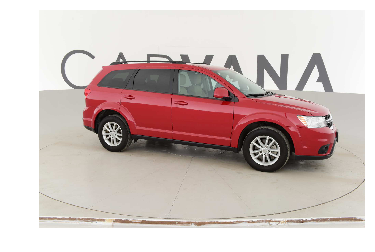

/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1280, 1918)


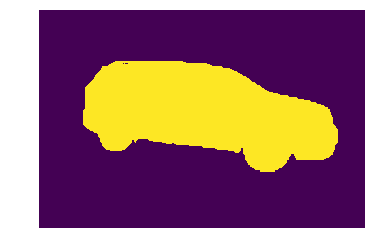

(1280, 1918, 3)


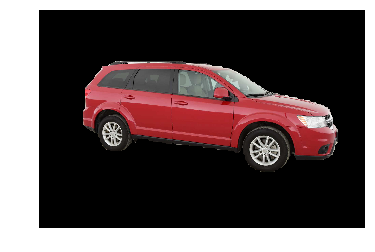

(1280, 1918, 3)


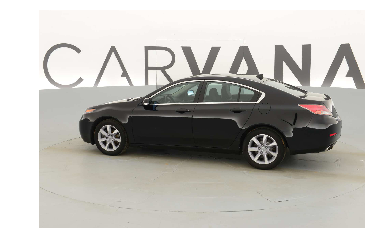

(1280, 1918)


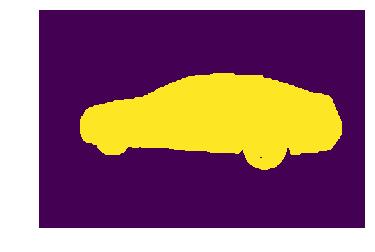

(1280, 1918, 3)


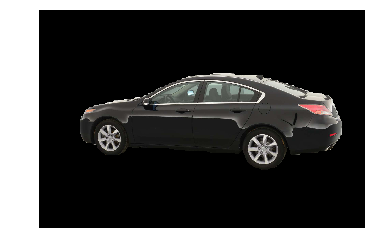

(1280, 1918, 3)


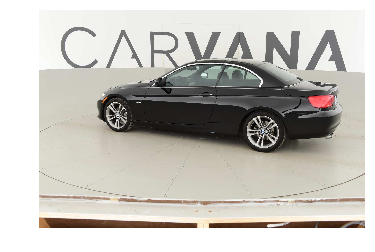

(1280, 1918)


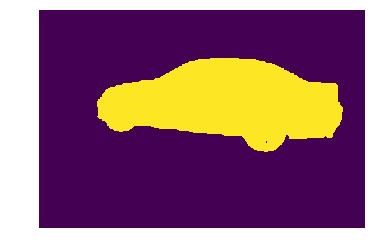

(1280, 1918, 3)


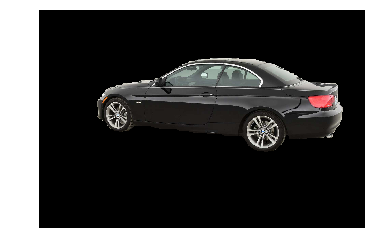

(1280, 1918, 3)


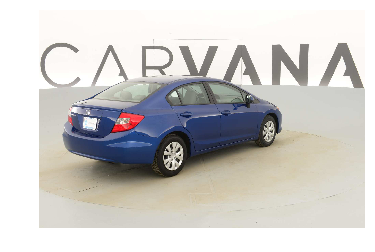

(1280, 1918)


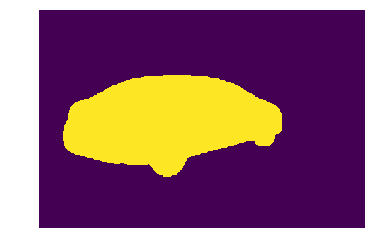

(1280, 1918, 3)


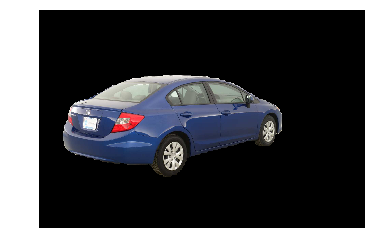

(1280, 1918, 3)


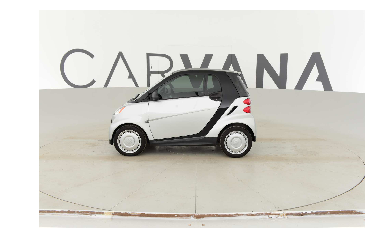

(1280, 1918)


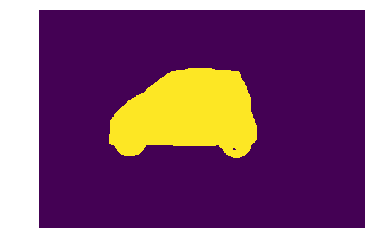

(1280, 1918, 3)


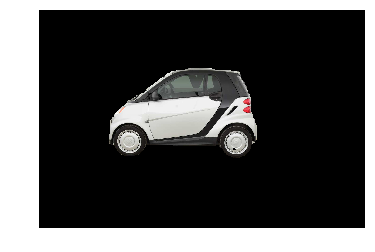

In [70]:
# Visualize performance on first 5 test imgs
for img_path in os.listdir(TEST_PATH)[0:5]:
    img_id = get_img_id(img_path)
    test_img = load_image(img_id, TEST_PATH)
    print(test_img.shape)
    plt.imshow(test_img)
    plt.axis('off')
    plt.show()
    
    resized_test_img = resize_img(test_img)

    pred_mask = model.predict(np.expand_dims(resized_test_img, axis=0))
    pred_mask = pred_mask.reshape(pred_mask.shape[1], pred_mask.shape[2])
    pred_mask = rescale(pred_mask, 10)
    pred_mask = pred_mask[:, 0:1918]
    
    pred_mask[pred_mask <= 0.5] = 0
    pred_mask[pred_mask > 0.5] = 1
    
# #     pred_mask_rle = rle_to_string(rle_encode(pred_mask))
# #     result.append((img_path, pred_mask_rle))
    
    print(pred_mask.shape)
    plt.imshow(pred_mask)
    plt.axis('off')
    plt.show()
    
    rgb_pred_mask = gray2rgb(pred_mask)
    masked_img = test_img * rgb_pred_mask
    print(masked_img.shape)
    imgplot = plt.imshow(masked_img)
    plt.axis('off')
    plt.show()

In [71]:
test_img_paths = os.listdir(TEST_PATH)
test_img_ids = list(map(get_img_id, test_img_paths))

TEST_BATCH_SIZE = 16
NUM_BATCHES = int(math.ceil(len(test_img_ids) / TEST_BATCH_SIZE))

result = []
for batch in tqdm(range(NUM_BATCHES)):
    start = batch * TEST_BATCH_SIZE
    end = start + TEST_BATCH_SIZE
    end = len(test_img_ids) if end > len(test_img_ids) else end
    test_imgs = load_imgs(test_img_ids[start:end], TEST_PATH)
    resized_test_imgs = resize_imgs(test_imgs)
    pred_masks = model.predict(resized_test_imgs)
    clean_masks = rescale_and_clean_masks(pred_masks)
    rles = rle_masks(clean_masks)
    result.extend(zip(test_img_paths[start:end], rles))

sub_ts = str(int(time.time()))
submission_df = pd.DataFrame.from_records(result, columns=['img', 'rle_mask'])
sub_file_path = os.path.join(SUBMISSION_PATH, 'malhot-submission-{}.csv'.format(sub_ts))
submission_df.to_csv(sub_file_path, index=False)
print('Generated submission {}'.format(sub_file_path))

  0%|          | 0/6254 [00:00<?, ?it/s]/kaggle/dev/ashish/carvana-image-masking-challenge/car/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 6254/6254 [8:51:47<00:00,  5.11s/it]  


Generated submission /kaggle/dev/carvana-image-masking-challenge-data/submissions/malhot-submission-1503802126.csv


In [73]:
# Reduce random dots in output masks
# new_result = []
# for idx in tqdm(range(len(result))):
#     img_path = result[idx][0]
#     mask = result[idx][1]
#     rle_decoded_mask = rle_decode(mask, (HEIGHT_ORIG, WIDTH_ORIG, 1))
#     limg = measure.label(rle_decoded_mask)
#     props = measure.regionprops(limg)
#     props = sorted(props, key=lambda p: -p.area)
#     # Erase all except the biggest blob
#     rle_decoded_mask &= (limg == props[0].label)
#     new_result.append((img_path, rle_to_string(rle_encode(rle_decoded_mask))))

In [74]:
# sub_ts = str(int(time.time()))
# submission_df = pd.DataFrame.from_records(new_result, columns=['img', 'rle_mask'])
# sub_file_path = os.path.join(SUBMISSION_PATH, 'malhot-submission-{}.csv'.format(sub_ts))
# submission_df.to_csv(sub_file_path, index=False)
# print('Generated submission {}'.format(sub_file_path))